In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pykrige import OrdinaryKriging

import os

## Data reading    
 - [ ] read origin data
 - [ ] read baikal obris
 - [ ] read baikal normalazed matrix 

In [2]:
plt.style.use('Solarize_Light2')   # try another styles: 'classic', 'Solarize_Light2'
driver = "~/"  # "G:/
pwd = os.path.join(driver, '1_Data1/sea/')
srcDataPath = os.path.join(pwd, "AllSea.txt")
obrisDataPath = os.path.join(driver, "1_Data1/obris/obris.dat")
batimetrFilePath = os.path.join(driver, "1_Data1/batimetria/b1.txt")
# srcData = "~/methaneSea.dat
srcDataPath

'~/1_Data1/sea/AllSea.txt'

In [3]:
obris = pd.read_csv(obrisDataPath,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                   )

In [4]:
## set grid
longStep = 0.02
latStep = 0.01

In [5]:
gdf = pd.read_csv('wholeBaikalGrid.dat', sep='\t')
gdf.drop('Unnamed: 0', axis='columns', inplace=True)
gdf['long'] = ((gdf['long']/longStep).round()*longStep*1000).round().astype('int')
gdf['lat'] = ((gdf['lat']/latStep).round()*latStep*1000).round().astype('int')
gdf['Longitude'] = gdf['long']/1000
gdf['Latitude'] = gdf['lat']/1000
gdf['norm_x'] = (gdf['toWest']/(gdf['toWest'] + gdf['toEast'])*25).astype('int')
gdf['norm_y'] = (gdf['toSud']/(gdf['toSud'] + gdf['toNord'])*400).astype('int')

gdf.loc[(gdf['long']==104000) & (gdf['lat']==51630), :]

,long,lat,toWest,toEast,toSud,toNord,Longitude,Latitude,norm_x,norm_y
166,104000,51630,13.089468,5.410384,21.85412,594.877486,104.0,51.63,17,14


In [6]:
gdf

,long,lat,toWest,toEast,toSud,toNord,Longitude,Latitude,norm_x,norm_y
0,103720,51670,4.282972,0.480521,4.282969,603.299686,103.72,51.67,22,2
1,103720,51680,3.193634,0.978128,3.193617,602.433790,103.72,51.68,19,2
2,103720,51690,2.128147,0.901280,2.128101,601.568702,103.72,51.69,17,1
3,103720,51700,1.154543,0.842088,1.154423,600.704425,103.72,51.70,14,0
4,103720,51710,0.781786,0.781786,0.781556,599.840963,103.72,51.71,12,0
...,...,...,...,...,...,...,...,...,...,...
21945,109940,55650,15.613542,0.188277,600.173257,15.613344,109.94,55.65,24,389
21946,109940,55660,14.832622,1.053897,600.951172,14.832181,109.94,55.66,23,390
21947,109940,55670,14.096272,1.117307,601.730135,14.095565,109.94,55.67,23,390
21948,109940,55680,13.411836,0.502898,602.510140,13.410838,109.94,55.68,24,391


In [7]:
df = pd.read_csv(os.path.join(pwd, "BaikalJul2024Sea.dat"),  #"AllSea.txt"
                 header=0,
                 usecols=['Longitude', 'Latitude', 'DateTime', 'cCH4Wtr', 'cCO2Wtr', 'dpCO2', 'dpCH4'],
                 # skip_blank_lines=True,
                 skipinitialspace=True,
                 na_values='',
                 skiprows=[],
                 sep='\t',
                 decimal='.',
                 #nrows=5000,
                 parse_dates=['DateTime'],
                 dayfirst=False
                 )

In [8]:
df['year'] = df['DateTime'].dt.year

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
## check for bad data
df.dropna(subset=['dpCO2']).sort_values(by='dpCO2').tail(2)

,DateTime,Longitude,Latitude,cCO2Wtr,cCH4Wtr,dpCO2,dpCH4,year
37339,2024-08-01 08:31:00,109.335701,54.932181,1.098148,88.808077,124.364975,1.290635,2024
14212,2024-07-27 00:02:00,105.351168,51.773479,7.378558,66.580176,3789.789506,0.703355,2024


In [11]:
for yr in range(2013, 2025):
    t = df.loc[(df['year'] == yr) & df['dpCO2']].shape
    print(f'{yr}: {t[0]}')

2013: 0
2014: 0
2015: 0
2016: 0
2017: 0
2018: 0
2019: 0
2020: 0
2021: 0
2022: 0
2023: 0
2024: 38770


In [12]:
df['long'] = ((df['Longitude']/longStep).round()*longStep*1000).round().astype('int')
df['lat'] = ((df['Latitude']/latStep).round()*latStep*1000).round().astype('int')
df

,DateTime,Longitude,Latitude,cCO2Wtr,cCH4Wtr,dpCO2,dpCH4,year,long,lat
0,2024-07-23 17:04:40,104.870600,51.847900,NaN,NaN,NaN,NaN,2024,104880,51850
1,2024-07-23 17:05:00,104.870599,51.847897,NaN,NaN,NaN,NaN,2024,104880,51850
2,2024-07-23 17:05:20,104.870597,51.847893,0.462544,727.214374,-157.813678,25.772976,2024,104880,51850
3,2024-07-23 17:05:40,104.870596,51.847890,0.463136,758.927630,-157.477323,26.980828,2024,104880,51850
4,2024-07-23 17:06:00,104.870595,51.847886,0.466470,712.120981,-155.688665,25.197980,2024,104880,51850
...,...,...,...,...,...,...,...,...,...,...
58705,2024-08-06 07:13:00,105.069524,51.896797,NaN,NaN,NaN,NaN,2024,105060,51900
58706,2024-08-06 07:13:20,105.069128,51.897058,NaN,NaN,NaN,NaN,2024,105060,51900
58707,2024-08-06 07:13:40,105.068733,51.897319,NaN,NaN,NaN,NaN,2024,105060,51900
58708,2024-08-06 07:14:00,105.068337,51.897580,NaN,NaN,NaN,NaN,2024,105060,51900


In [13]:
#func_list = ['mean', 'count']
func_list = ['mean']
cols_to_calc = {#'cCH4Wtr': func_list,
                #'cCO2Wtr': func_list,
                'dpCO2': func_list,
                #'dpCH4': func_list,
               }
res = df.groupby(['year', 'long', 'lat'], as_index=False).agg(cols_to_calc)
res.columns = res.columns.get_level_values(0)
res

,year,long,lat,dpCO2
0,2024,103860,51670,-229.009626
1,2024,103880,51670,-187.483905
2,2024,103880,51680,-184.409428
3,2024,103900,51660,-161.900916
4,2024,103900,51670,-177.363383
...,...,...,...,...
2212,2024,109780,55350,-257.270915
2213,2024,109780,55360,-249.257152
2214,2024,109780,55370,-259.351734
2215,2024,109800,55360,-264.406315


In [14]:
res = pd.merge(left=res, right=gdf, left_on=['long', 'lat'], right_on=['long', 'lat'], how='left')

In [15]:
res['norm_x'] = res['toWest']/(res['toWest'] + res['toEast'])
res['norm_y'] = res['toSud']/(res['toSud'] + res['toNord'])
res = res.dropna(subset=['dpCO2', 'norm_x', 'norm_y'])

In [16]:
res.describe()

,year,long,lat,dpCO2,toWest,toEast,toSud,toNord,Longitude,Latitude,norm_x,norm_y
count,1577.0,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000,1577.000000
mean,2024.0,107425.732403,53374.039315,-197.672539,21.948365,22.143081,317.390476,308.205617,107.425732,53.374039,0.491581,0.510477
std,0.0,1871.563073,1327.528803,47.224021,14.540292,13.972284,181.156861,187.715321,1.871563,1.327529,0.270765,0.297079
min,2024.0,103860.000000,51510.000000,-348.754588,0.122784,0.222453,11.222672,9.495992,103.860000,51.510000,0.002718,0.018443
25%,2024.0,105540.000000,51910.000000,-229.865700,9.868166,10.922372,127.389824,149.968841,105.540000,51.910000,0.282216,0.199217
50%,2024.0,107940.000000,53390.000000,-193.869707,20.129090,21.146121,341.839974,287.913525,107.940000,53.390000,0.467597,0.541668
75%,2024.0,109160.000000,54490.000000,-165.323593,31.127682,29.768693,479.494130,508.228144,109.160000,54.490000,0.717852,0.758038
max,2024.0,109800.000000,55730.000000,-63.492035,64.226918,65.872581,592.441390,597.282550,109.800000,55.730000,0.996116,0.984224


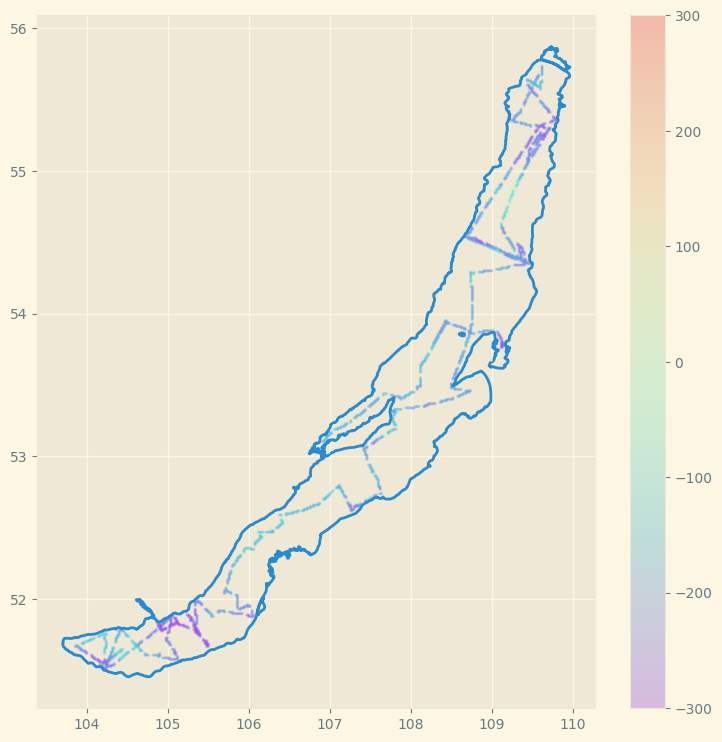

In [17]:
plt.rcParams['figure.figsize'] = [9, 9]

plt.scatter(res['long']/1000, res['lat']/1000, c=res['dpCO2'], cmap='rainbow', s=2, alpha=0.2)
plt.colorbar()
plt.clim(-300, 300)
#plt.xlim(103.6, 105)
#plt.ylim(51.4, 52)
plt.plot('long', 'lat', data=obris)

In [18]:
lat = res['norm_y'].values
long = res['norm_x'].values
dpCO2 = res['dpCO2'].values
gridx = np.linspace(0, 1, 25)
gridy = np.linspace(0, 1, 400)

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 380.8939985127297
Full Sill: 2343.0473450373497
Range: 1.1113286088854315
Nugget: 1962.15334652462 



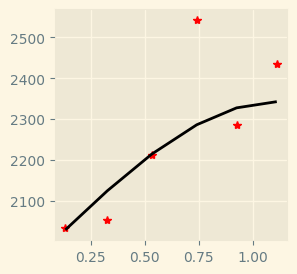

Calculating statistics on variogram model fit...


In [21]:
plt.rcParams['figure.figsize'] = [3, 3]
ok = OrdinaryKriging(long,
                     lat,
                     dpCO2,
                     variogram_model='spherical',
                     coordinates_type='geographic',
                     verbose=True,
                     enable_plotting=True)

In [22]:
z_interp, ss = ok.execute('grid', gridx, gridy)

Executing Ordinary Kriging...



In [23]:
z_interp.data.shape

(400, 25)

In [24]:
surdf = pd.DataFrame([[y, x, z_interp[x, y]] for x in range(400) for y in range(25)], columns=['norm_x', 'norm_y', 'dpCO2All'])

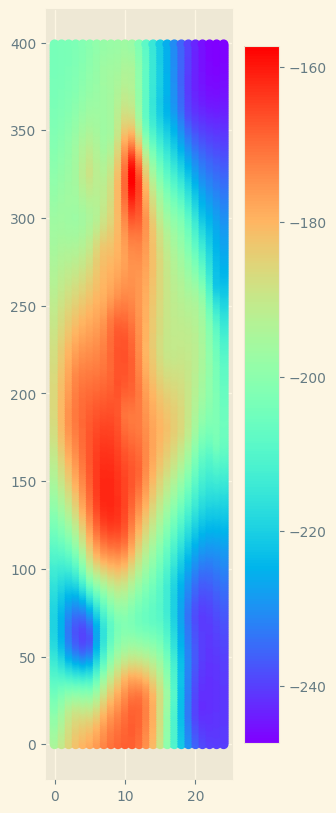

In [25]:
plt.rcParams['figure.figsize'] = [3, 10]
plt.scatter('norm_x', 'norm_y', data=surdf, c=surdf['dpCO2All'], cmap='rainbow')
plt.colorbar()

In [26]:
gdf = pd.merge(left=gdf, right=surdf, left_on=['norm_x', 'norm_y'], right_on=['norm_x', 'norm_y'], how='left')

In [27]:
gdf

,long,lat,toWest,toEast,toSud,toNord,Longitude,Latitude,norm_x,norm_y,dpCO2All
0,103720,51670,4.282972,0.480521,4.282969,603.299686,103.72,51.67,22,2,-240.147134
1,103720,51680,3.193634,0.978128,3.193617,602.433790,103.72,51.68,19,2,-230.024131
2,103720,51690,2.128147,0.901280,2.128101,601.568702,103.72,51.69,17,1,-210.669057
3,103720,51700,1.154543,0.842088,1.154423,600.704425,103.72,51.70,14,0,-180.862873
4,103720,51710,0.781786,0.781786,0.781556,599.840963,103.72,51.71,12,0,-170.377856
...,...,...,...,...,...,...,...,...,...,...,...
21945,109940,55650,15.613542,0.188277,600.173257,15.613344,109.94,55.65,24,389,-246.603728
21946,109940,55660,14.832622,1.053897,600.951172,14.832181,109.94,55.66,23,390,-247.100054
21947,109940,55670,14.096272,1.117307,601.730135,14.095565,109.94,55.67,23,390,-247.100054
21948,109940,55680,13.411836,0.502898,602.510140,13.410838,109.94,55.68,24,391,-246.697751


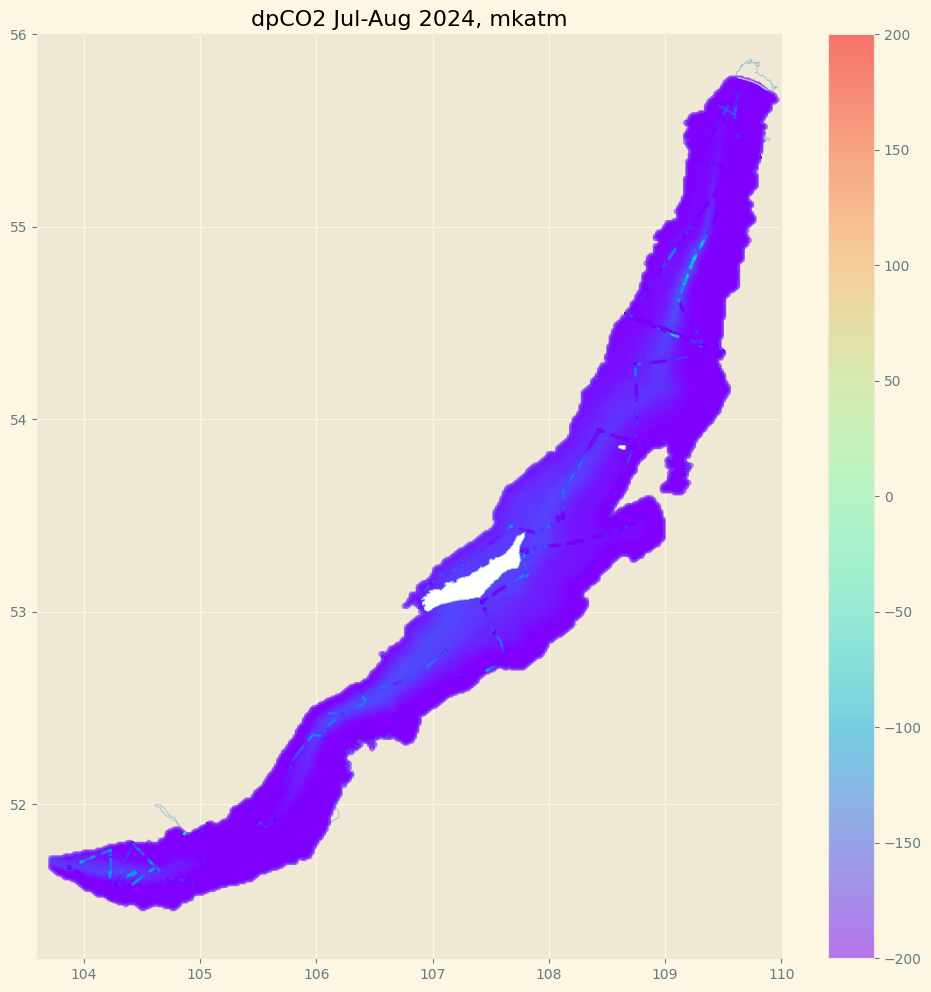

In [28]:
plt.rcParams['figure.figsize'] = [12, 12]

plt.scatter('Longitude', 'Latitude', data=gdf, c=gdf['dpCO2All'], cmap='rainbow', s=20, alpha=0.5, linewidth=0)
plt.clim(-200, 200)
plt.colorbar(alpha=1)
plt.scatter('Longitude', 'Latitude', data=df, c=df['dpCO2'], cmap='rainbow', s=5, alpha=0.1, linewidth=0)
plt.clim(-200, 200)
plt.xlim(103.6, 110)
plt.ylim(51.2, 56)
plt.plot('long', 'lat', data=obris, alpha=0.5, linewidth=0.5)
plt.fill('long', 'lat', data=obris.iloc[4845:,:], c='white', alpha=1, linewidth=0.5)
plt.title(f'dpCO2 Jul-Aug 2024, mkatm')
plt.savefig(f'surf_dpCO2_jul2024.png')


In [ ]:
#for year in [2013, 2016, 2017, 2018, 2021, 2022, 2023, 2024]:
for year in [2024]:
    lat = res.loc[res['year']==year,'norm_y'].values
    long = res.loc[res['year']==year,'norm_x'].values
    value = res.loc[res['year']==year,'dpCO2'].values
    gridx = np.linspace(0, 1, 25)
    gridy = np.linspace(0, 1, 400)
    
    ok = OrdinaryKriging(long,
                         lat,
                         value,
                         variogram_model='spherical',
                         coordinates_type='geographic',
                         verbose=False,
                         enable_plotting=False)
    z_interp, ss = ok.execute('grid', gridx, gridy)
    
    surdf = pd.DataFrame([[y, x, z_interp[x, y]] for x in range(400) for y in range(25)], columns=['norm_x', 'norm_y', f'dpCO2{year}'])
    gdf = pd.merge(left=gdf, right=surdf, left_on=['norm_x', 'norm_y'], right_on=['norm_x', 'norm_y'], how='left')

In [ ]:
cycles=['dpCO22013', 'dpCO22016', 'dpCO22017', 'dpCO22018', 'dpCO22021', 'dpCO22022', 'dpCO22023', 'dpCO22024']
gdf['dpCO2All']=0
for cycle in cycles:
    gdf['dpCO2All'] += gdf[cycle]
gdf['dpCO2All']/=len(cycles)
gdf

In [ ]:
gdf.to_csv(os.path.join(pwd, 'pdCO2Surfer.txt'), sep='\t')

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 12]

In [ ]:
cycles=['dpCO2All', 'dpCO22013', 'dpCO22016', 'dpCO22017', 'dpCO22018', 'dpCO22021', 'dpCO22022', 'dpCO22023', 'dpCO22024']
cycles=['All', 2013, 2016, 2017, 2018, 2021, 2022, 2023, 2024]
for cycle in cycles:
    if cycle == 'All':
        plt.scatter('Longitude', 'Latitude', data=df, c=df['dpCO2'], cmap='rainbow', s=5, alpha=0.1, linewidth=0)
    else:
        plt.scatter('Longitude', 'Latitude', data=df.loc[df['year']==cycle,:], c=df.loc[df['year']==cycle,'dpCO2'], cmap='rainbow', s=5, alpha=0.3, linewidth=0)
    plt.clim(-200, 200)
    plt.scatter('Longitude', 'Latitude', data=gdf, c=gdf[f'dpCO2{cycle}'], cmap='rainbow', s=5, alpha=0.5, linewidth=0)
    plt.colorbar(alpha=1)
    plt.clim(-200, 200)
    plt.xlim(103.6, 110)
    plt.ylim(51.2, 56)
    plt.plot('long', 'lat', data=obris, alpha=0.5, linewidth=0.5)
    plt.fill('long', 'lat', data=obris.iloc[4845:,:], c='white', alpha=1, linewidth=0.5)
    plt.title(f'dpCO2_{cycle}, mkatm')
    plt.savefig(f'surf_dpCO2_{cycle}.png')
    plt.close()


In [ ]:
gdf.describe()